On downloaded GEFSv12 reforecast data, preprocess IVT and freezing level

In [1]:
## import libraries
import os, sys
import subprocess
import numpy as np
import pandas as pd
from datetime import timedelta
import xarray as xr
from scipy.integrate import trapz
# import dask
from dask.distributed import progress # this gives us a nice progress bar
path_to_repo = '/cw3e/mead/projects/cwp140/scratch/dnash/repos/SEAK_AR_impacts/'
sys.path.append(path_to_repo+'modules')
import GEFSv12_funcs as gefs

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
## set up paths
path_to_out  = path_to_repo + 'out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = path_to_repo +'figs/'      # figures
path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only

### functions for preprocessing

In [2]:
def process_GEFSv12_freezing_level(row):
    ARID = str(int(row['trackID']))
    print('Processing .... AR ID {0}'.format(ARID))
    ## for each AR event between 2000 and 2019, create a list of dates to download GEFSv2 data
    new_start = row['start_date'] - timedelta(days=7)
    date_lst = pd.date_range(new_start, row['end_date'], freq='1D')
    
    ## need year and date values for finding files on S3 bucket
    year = date_lst.strftime("%Y").values
    date = date_lst.strftime("%Y%m%d").values
    
    ## save list of years and list of dates as text files in out
    np.savetxt(r'../out/freezing_level/{0}_yrlst.txt'.format(ARID), year, fmt='%s')
    np.savetxt(r'../out/freezing_level/{0}_datelst.txt'.format(ARID), date, fmt='%s')
    
    ## run download_GEFSv12_reforecast.sh to download IVT data to folder named 'ARID'
    ## run bash script to download files for AR event
    bash_script = "../downloads/download_GEFSv12_reforecast.sh"
    # print(subprocess.run([bash_script, ARID, 'freezing_level']))
    
    ## preprocess IVT data to single xarray ds for each AR event
    ## 7 days before AR makes landfall to end of AR event
    print('Preprocessing Freezing Level ....')
    varname_lst = ['tmp', 'hgt']
    ds_lst = []
    for i, varname in enumerate(varname_lst):
        ds = gefs.read_and_regrid_prs_var(varname, ARID, date, year, 'freezing_level')
        ds_lst.append(ds)

    ds = xr.merge(ds_lst) # merge t and gh into single ds
    ds_freeze = gefs.calc_freezing_level(ds) # calculate freezing level (m)

    ## save freezing level data to netCDF file
    print('Writing {0} to netCDF ....'.format(ARID))
    out_fname = path_to_data + 'preprocessed/GEFSv12_reforecast/freezing_level/{0}_freezing_level.nc'.format(ARID)
    ds_freeze.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')
    
    ## delete original downloaded data - run another clean-up bash file
    bash_script = "../downloads/clean_GEFSv12_reforecast.sh"
    # print(subprocess.run([bash_script, ARID, 'freezing_level']))
    
    return ds_freeze

@dask.delayed
def process_GEFSv12_ivt(row):
    ARID = str(int(row['trackID']))
    print('Processing .... AR ID {0}, Index {1}'.format(ARID, index))
    ## for each AR event between 2000 and 2019, create a list of dates to download GEFSv2 data
    new_start = row['start_date'] - timedelta(days=7)
    date_lst = pd.date_range(new_start, row['end_date'], freq='1D')
    
    ## need year and date values for finding files on S3 bucket
    year = date_lst.strftime("%Y").values
    date = date_lst.strftime("%Y%m%d").values
    
    ## save list of years and list of dates as text files in out
    np.savetxt(r'../out/ivt/{0}_yrlst.txt'.format(ARID), year, fmt='%s')
    np.savetxt(r'../out/ivt/{0}_datelst.txt'.format(ARID), date, fmt='%s')
    
    ## run download_GEFSv12_reforecast.sh to download IVT data to folder named 'ARID'
    ## run bash script to download files for AR event
    bash_script = "../downloads/download_GEFSv12_reforecast.sh"
    # print(subprocess.run([bash_script, ARID, 'ivt']))
    
    ## preprocess IVT data to single xarray ds for each AR event
    ## 7 days before AR makes landfall to end of AR event
    print('Preprocessing IVT ....')
    varname_lst = ['ugrd', 'vgrd', 'spfh']
    ds_lst = []
    for i, varname in enumerate(varname_lst):
        ds = gefs.read_and_regrid_prs_var(varname, ARID, date, year, 'ivt')
        ds_lst.append(ds)

    ds = xr.merge(ds_lst) # merge u, v, and q into single ds
    ds = ds.sel(isobaricInhPa=slice(300, 1000))
    ds = ds.reindex(isobaricInhPa=ds.isobaricInhPa[::-1])
    ds_IVT = gefs.calc_IVT(ds) # calculate IVT

    ## save IVT data to netCDF file
    print('Writing {0} to netCDF ....'.format(ARID))
    out_fname = path_to_data + 'preprocessed/GEFSv12_reforecast/ivt/{0}_ivt.nc'.format(ARID)
    ds_IVT.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')
    
    ## delete original downloaded data - run another clean-up bash file
    bash_script = "../downloads/clean_GEFSv12_reforecast.sh"
    # print(subprocess.run([bash_script, ARID, 'ivt']))
    
    return out_fname


# @dask.delayed
def process_GEFSv12_prec(row):
    ARID = str(int(row['trackID']))
    print('Processing .... AR ID {0}, Index {1}'.format(ARID, index))
    ## for each AR event between 2000 and 2019, create a list of dates to download GEFSv2 data
    new_start = row['start_date'] - timedelta(days=7)
    date_lst = pd.date_range(new_start, row['end_date'], freq='1D')
    
    ## need year and date values for finding files on S3 bucket
    year = date_lst.strftime("%Y").values
    date = date_lst.strftime("%Y%m%d").values
    
    ## save list of years and list of dates as text files in out
    np.savetxt(r'../out/prec/{0}_yrlst.txt'.format(ARID), year, fmt='%s')
    np.savetxt(r'../out/prec/{0}_datelst.txt'.format(ARID), date, fmt='%s')
    
    ## run download_GEFSv12_reforecast.sh to download IVT data to folder named 'ARID'
    ## run bash script to download files for AR event
    bash_script = "../downloads/download_GEFSv12_reforecast.sh"
    # print(subprocess.run([bash_script, ARID, 'prec']))
    
    ## preprocess precipitation data to single xarray ds for each AR event
    ## 7 days before AR makes landfall to end of AR event
    print('Preprocessing precipitation ....')
    prec = gefs.read_sfc_var('apcp', 'tp', ARID)

    ## save precipitation data to netCDF file
    print('Writing {0} to netCDF ....'.format(ARID))
    out_fname = path_to_data + 'preprocessed/GEFSv12_reforecast/prec/{0}_prec.nc'.format(ARID)
    prec.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')
    
    ## delete original downloaded data - run another clean-up bash file
    bash_script = "../downloads/clean_GEFSv12_reforecast.sh"
    print(subprocess.run([bash_script, ARID, 'prec']))
    
    return out_fname

In [3]:
path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
## pull filenames from preprocessed directory into a list of trackIDs
prec_trackIDs = gefs.list_of_processed_trackIDs('prec')
prec_trackIDs[0]

200901281209.0

In [5]:
## read AR duration file
duration_df = pd.read_csv(path_to_out + 'AR_track_duration_SEAK.csv')
duration_df['start_date'] = pd.to_datetime(duration_df['start_date'])
duration_df['end_date'] = pd.to_datetime(duration_df['end_date'])
duration_df.index = duration_df['start_date']
idx = ~duration_df['trackID'].isin(prec_trackIDs)
duration_df = duration_df[idx]
duration_df

,Unnamed: 0,trackID,start_date,end_date,duration
start_date,,,,,
2012-05-20 18:00:00,937,2.012052e+11,2012-05-20 18:00:00,2012-05-23 12:00:00,66.0
2012-05-22 06:00:00,938,2.012052e+11,2012-05-22 06:00:00,2012-05-22 12:00:00,6.0
2016-01-16 12:00:00,1236,2.016011e+11,2016-01-16 12:00:00,2016-01-19 06:00:00,66.0
2016-01-21 00:00:00,1237,2.016012e+11,2016-01-21 00:00:00,2016-01-21 18:00:00,18.0
2016-01-21 18:00:00,1238,2.016012e+11,2016-01-21 18:00:00,2016-01-22 00:00:00,6.0
...,...,...,...,...,...
2019-08-15 12:00:00,1494,2.019082e+11,2019-08-15 12:00:00,2019-08-15 18:00:00,6.0
2019-08-16 00:00:00,1495,2.019082e+11,2019-08-16 00:00:00,2019-08-21 12:00:00,132.0
2019-08-21 12:00:00,1496,2.019082e+11,2019-08-21 12:00:00,2019-08-22 06:00:00,18.0


In [6]:
idx = (duration_df['trackID'] == 201508151811) #
start_idx = int(duration_df.loc[idx]['Unnamed: 0'].values)
duration_df.loc[idx]

/tmp/ipykernel_14214/2286245965.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  start_idx = int(duration_df.loc[idx]['Unnamed: 0'].values)


,Unnamed: 0,trackID,start_date,end_date,duration
start_date,,,,,
2012-05-22 06:00:00,938,2.012052e+11,2012-05-22 06:00:00,2012-05-22 12:00:00,6.0


In [8]:
%%time
results = []
for index, row in duration_df.loc[idx].iterrows():
    # z = process_GEFSv12_freezing_level(row)
    z = process_GEFSv12_prec(row)
    results.append(z)

dask.compute(results)

Processing .... AR ID 201205220611, Index 2012-05-22 06:00:00
Preprocessing precipitation ....


ValueError: 'time' must have either an index or no index in all datasets, found 1/8 datasets with an index.

In [8]:
freeze = results[0]

In [12]:
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# extras


# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
from plotter import draw_basemap

In [23]:
np.ones([5, 6]) * np.arange(6)

array([[0., 1., 2., 3., 4., 5.],
       [0., 1., 2., 3., 4., 5.],
       [0., 1., 2., 3., 4., 5.],
       [0., 1., 2., 3., 4., 5.],
       [0., 1., 2., 3., 4., 5.]])

In [28]:
tmp = freeze.isel(time=0).freezing_level
# tmp = tmp.sel(lon=-180)
# tmp = tmp.sortby(tmp.lon)
tmp.lon.values


array([ 140.  ,  140.25,  140.5 ,  140.75,  141.  ,  141.25,  141.5 ,
        141.75,  142.  ,  142.25,  142.5 ,  142.75,  143.  ,  143.25,
        143.5 ,  143.75,  144.  ,  144.25,  144.5 ,  144.75,  145.  ,
        145.25,  145.5 ,  145.75,  146.  ,  146.25,  146.5 ,  146.75,
        147.  ,  147.25,  147.5 ,  147.75,  148.  ,  148.25,  148.5 ,
        148.75,  149.  ,  149.25,  149.5 ,  149.75,  150.  ,  150.25,
        150.5 ,  150.75,  151.  ,  151.25,  151.5 ,  151.75,  152.  ,
        152.25,  152.5 ,  152.75,  153.  ,  153.25,  153.5 ,  153.75,
        154.  ,  154.25,  154.5 ,  154.75,  155.  ,  155.25,  155.5 ,
        155.75,  156.  ,  156.25,  156.5 ,  156.75,  157.  ,  157.25,
        157.5 ,  157.75,  158.  ,  158.25,  158.5 ,  158.75,  159.  ,
        159.25,  159.5 ,  159.75,  160.  ,  160.25,  160.5 ,  160.75,
        161.  ,  161.25,  161.5 ,  161.75,  162.  ,  162.25,  162.5 ,
        162.75,  163.  ,  163.25,  163.5 ,  163.75,  164.  ,  164.25,
        164.5 ,  164

In [29]:
tmp

<xarray.DataArray 'freezing_level' (lat: 281, lon: 401)>
array([[2329.1597, 2324.65  , 2320.3083, ..., 1135.718 , 1158.1837,
        1171.4398],
       [2325.2798, 2323.3416, 2331.1675, ..., 1097.6292, 1129.2051,
        1151.7241],
       [2331.5625, 2332.0251, 2332.488 , ..., 1109.2981, 1140.6508,
        1162.7484],
       ...,
       [4969.304 , 4972.2812, 4975.2964, ..., 5231.3003, 5225.7495,
        5220.2837],
       [4973.856 , 4982.099 , 4990.3433, ..., 5232.561 , 5229.862 ,
        5227.1875],
       [4978.6284, 4992.2764, 5005.76  , ..., 5233.8613, 5234.133 ,
        5234.404 ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-08-17T03:00:00
  * lat      (lat) float64 70.0 69.75 69.5 69.25 69.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float64 140.0 140.2 140.5 140.8 ... -120.5 -120.2 -120.0

[ 140.  150.  160.  170. -180. -170. -160. -150. -140. -130. -120.]


/tmp/ipykernel_7718/1137267728.py:33: MatplotlibDeprecationWarning: Passing an undefined label_mode is deprecated since 3.7 and will become an error two minor releases later. To silence this warning, pass "keep", which gives the same behaviour.
  axgr = AxesGrid(fig, 111, axes_class=axes_class,


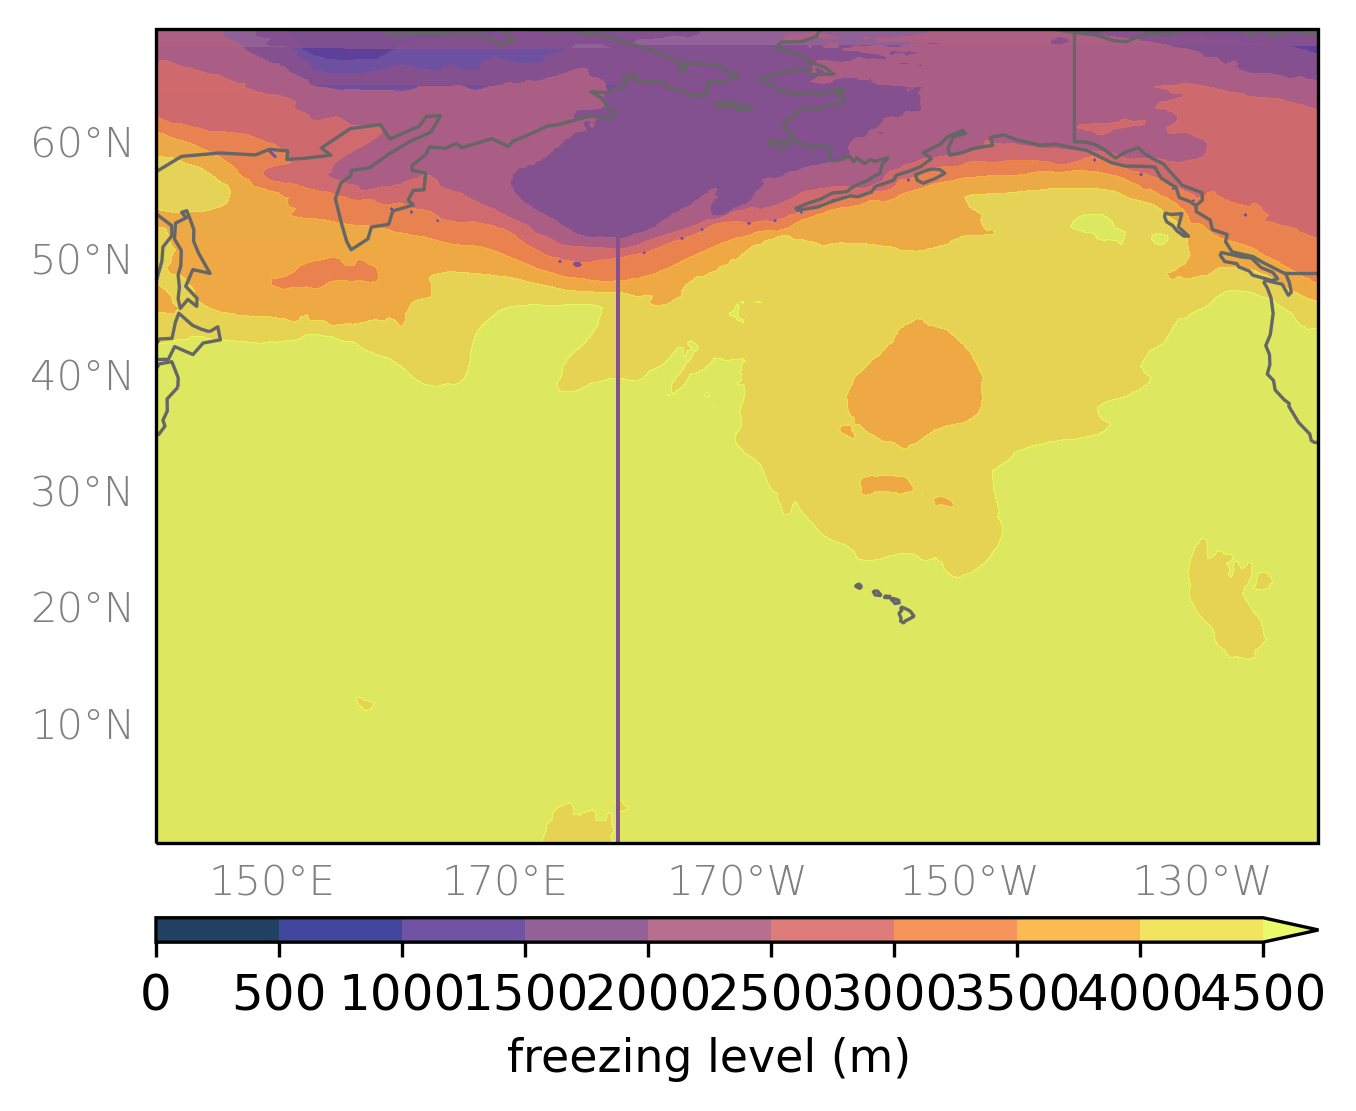

In [30]:
# Set up projection
cm = 180
mapcrs = ccrs.PlateCarree(central_longitude=cm)
datacrs = ccrs.PlateCarree()
ext1 = [140., -120., 0, 70]

# Set tick/grid locations
lats = freeze.lat.values
lons = freeze.lon.values
if cm == 0:
    dx = np.arange(lons.min().round(),lons.max().round()+2,2)
    dy = np.arange(lats.min().round(),lats.max().round()+1,1)
elif cm == 180:
    dx = lons[::40]
    dy = lats[::40]
print(dx)

##### Create figure
fig = plt.figure(figsize=(5, 5))
fig.dpi = 300
fname = path_to_figs + 'test_freeze'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

###########################
### FREEZING LEVEL PLOT ###
###########################

for k, ax in enumerate(axgr):
    # data = freeze.isel(time=0).freezing_level.values
    data=tmp
    # data, lons = add_cyclic_point(data, coord=lons%360)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)

    # Contour Filled
    cflevs = np.arange(0, 5000, 500)
    cmap = cmo.thermal
    cf = ax.contourf(lons, lats, data, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('freezing level (m)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [18]:
%%time
results = []
for index, row in duration_df.iloc[start_idx+1:].iterrows():
    z = process_GEFSv12_prec(row)
    results.append(z)

dask.compute(results)

Processing .... AR ID 200610201812, Index 2006-10-23 00:00:00
Processing .... AR ID 200610151213, Index 2006-10-23 00:00:00
ARID: 200610201812
/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/prec/200610201812/
ARID: 200610151213
/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/prec/200610151213/
download: s3://noaa-gefs-retrospective/GEFSv12/reforecast/2006/2006101000/c00/Days:1-10/apcp_sfc_2006101000_c00.grib2 to ../../../data/downloads/GEFSv12_reforecast/prec/200610151213/apcp_sfc_2006101000_c00.grib2
download: s3://noaa-gefs-retrospective/GEFSv12/reforecast/2006/2006101600/c00/Days:1-10/apcp_sfc_2006101600_c00.grib2 to ../../../data/downloads/GEFSv12_reforecast/prec/200610201812/apcp_sfc_2006101600_c00.grib2
download: s3://noaa-gefs-retrospective/GEFSv12/reforecast/2006/2006101100/c00/Days:1-10/apcp_sfc_2006101100_c00.grib2 to ../../../data/downloads/GEFSv12_reforecast/prec/200610151213/apcp_sfc_2006101100_c00.grib2
download: s3:/

(['/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/GEFSv12_reforecast/prec/200610151213_prec.nc',
  '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/GEFSv12_reforecast/prec/200610201812_prec.nc'],)

[-180. -178. -176. -174. -172. -170. -168. -166. -164. -162. -160. -158.
 -156. -154. -152. -150. -148. -146. -144. -142. -140. -138. -136. -134.
 -132. -130. -128. -126. -124. -122. -120. -118. -116. -114. -112. -110.
 -108. -106. -104. -102. -100.  -98.  -96.  -94.  -92.  -90.  -88.  -86.
  -84.  -82.  -80.  -78.  -76.  -74.  -72.  -70.  -68.  -66.  -64.  -62.
  -60.  -58.  -56.  -54.  -52.  -50.  -48.  -46.  -44.  -42.  -40.  -38.
  -36.  -34.  -32.  -30.  -28.  -26.  -24.  -22.  -20.  -18.  -16.  -14.
  -12.  -10.   -8.   -6.   -4.   -2.    0.    2.    4.    6.    8.   10.
   12.   14.   16.   18.   20.   22.   24.   26.   28.   30.   32.   34.
   36.   38.   40.   42.   44.   46.   48.   50.   52.   54.   56.   58.
   60.   62.   64.   66.   68.   70.   72.   74.   76.   78.   80.   82.
   84.   86.   88.   90.   92.   94.   96.   98.  100.  102.  104.  106.
  108.  110.  112.  114.  116.  118.  120.  122.  124.  126.  128.  130.
  132.  134.  136.  138.  140.  142.  144.  146.  1

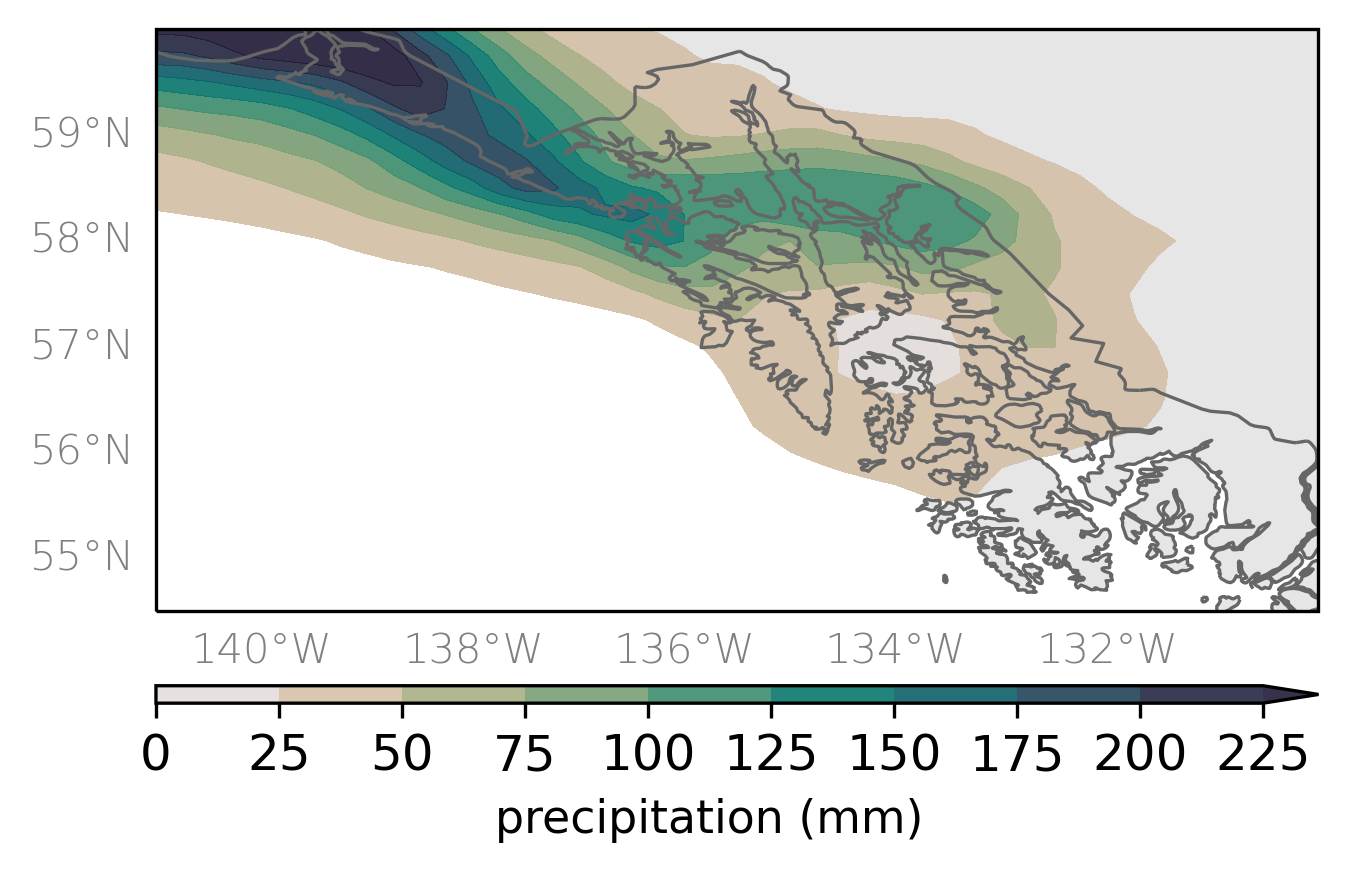

In [31]:
# Set up projection
cm = 0
mapcrs = ccrs.PlateCarree(central_longitude=cm)
datacrs = ccrs.PlateCarree()
ext1 = [-141., -130., 54.5, 60.] # extent of SEAK 

# Set tick/grid locations
lats = prec.lat.values
lons = prec.lon.values
if cm == 0:
    dx = np.arange(lons.min().round(),lons.max().round()+2,2)
    dy = np.arange(lats.min().round(),lats.max().round()+1,1)
elif cm == 180:
    dx = lons[::40]
    dy = lats[::40]
print(dx)

##### Create figure
fig = plt.figure(figsize=(5, 5))
fig.dpi = 300
fname = path_to_figs + 'test_prec'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='L')

######################
### PREC COMPOSITE ###
######################

for k, ax in enumerate(axgr):
    ds_plot = prec.sum('time')
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)

    # Contour Filled
    cflevs = np.arange(0, 250, 25) # levels for prec
    cmap = cmo.rain # cmap for precipitation
    cf = ax.contourf(lons, lats, ds_plot.tp, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('precipitation (mm)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [35]:
%%time
results = []
for index, row in duration_df.loc[idx].iterrows():
    z = process_GEFSv12_ivt(row)
    results.append(z)

dask.compute(results)

Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/ivt/201508151811/ugrd_pres_2015081700_c00.grib2.923a8.idx' incompatible with GRIB file


Processing .... AR ID 201508151811, Index 2015-08-17 06:00:00
Preprocessing IVT ....


Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/ivt/201508151811/ugrd_pres_2015081800_c00.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/ivt/201508151811/ugrd_pres_2015081900_c00.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/ivt/201508151811/ugrd_pres_abv700mb_2015081700_c00.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/ivt/201508151811/ugrd_pres_abv700mb_2015081800_c00.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/GEFSv12_reforecast/ivt/201508151811/ugrd_pres_abv700mb_2015081900_c00.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dn

Writing 201508151811 to netCDF ....
CPU times: user 1min 29s, sys: 42.5 s, total: 2min 11s
Wall time: 1min 6s


(['/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/GEFSv12_reforecast/ivt/201508151811_ivt.nc'],)

In [39]:
ds_IVT = xr.open_dataset('/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/GEFSv12_reforecast/ivt/201508151811_ivt.nc', engine='netcdf4')
ds_IVT

<xarray.Dataset>
Dimensions:  (time: 24, lat: 281, lon: 401)
Coordinates:
  * time     (time) datetime64[ns] 2015-08-17T03:00:00 ... 2015-08-20
  * lat      (lat) float64 70.0 69.75 69.5 69.25 69.0 ... 1.0 0.75 0.5 0.25 0.0
  * lon      (lon) float64 140.0 140.2 140.5 140.8 ... -120.5 -120.2 -120.0
Data variables:
    ivtu     (time, lat, lon) float64 ...
    ivtv     (time, lat, lon) float64 ...
    ivt      (time, lat, lon) float64 ...

[ 140.  150.  160.  170. -180. -170. -160. -150. -140. -130. -120.]


/tmp/ipykernel_7718/1573976215.py:33: MatplotlibDeprecationWarning: Passing an undefined label_mode is deprecated since 3.7 and will become an error two minor releases later. To silence this warning, pass "keep", which gives the same behaviour.
  axgr = AxesGrid(fig, 111, axes_class=axes_class,


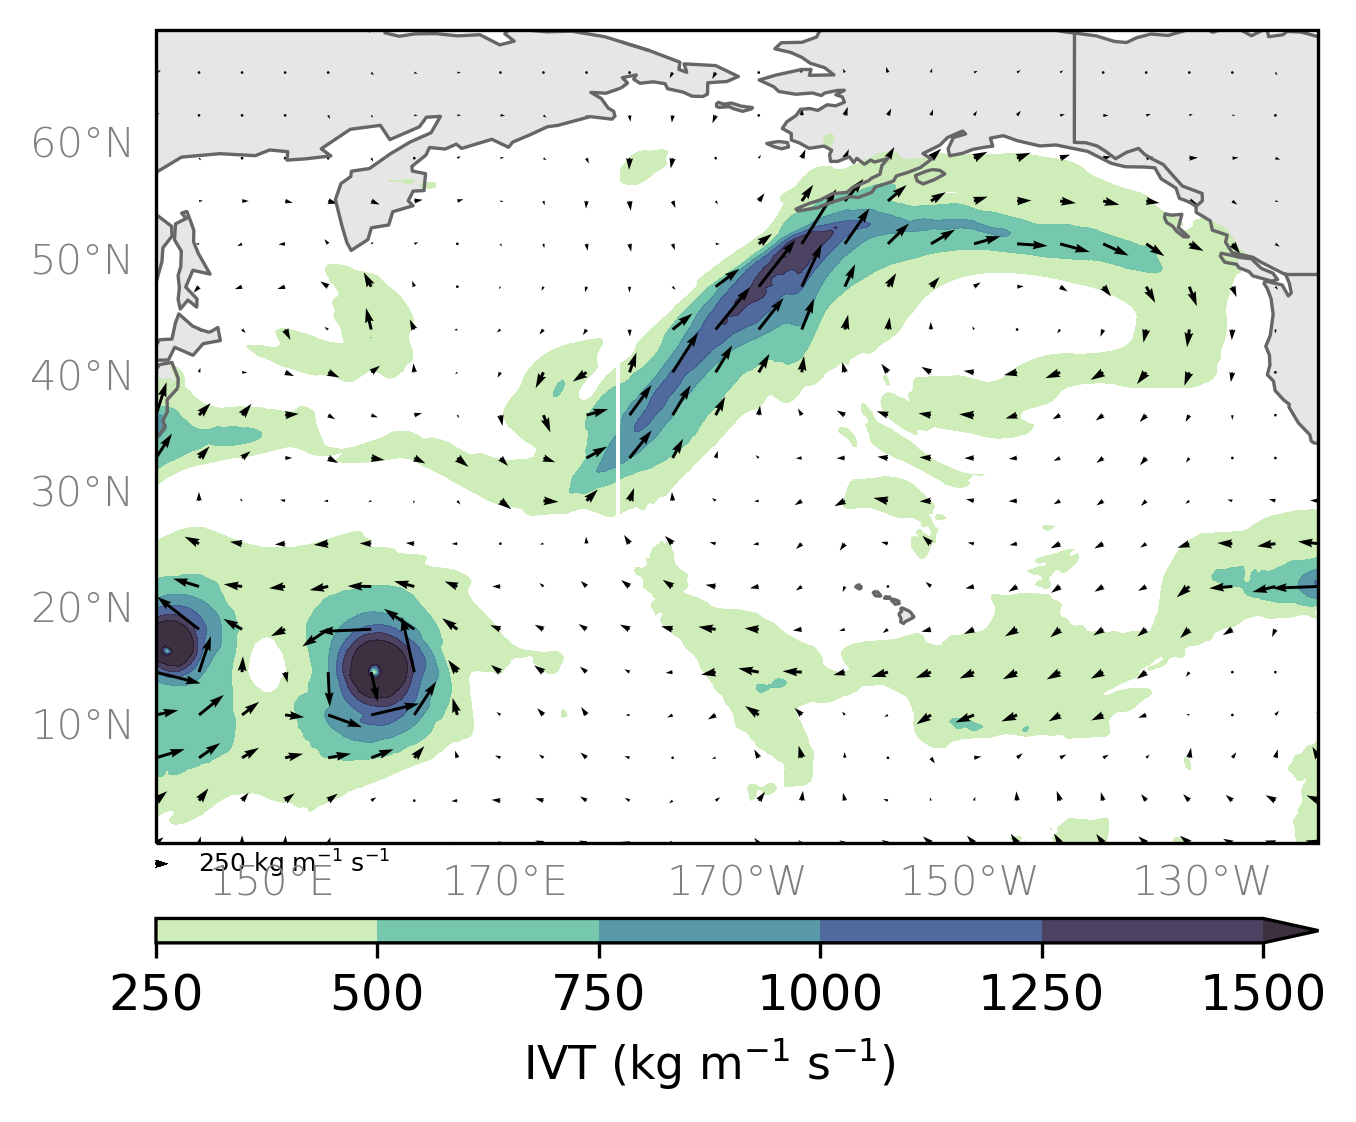

In [42]:
# Set up projection
cm = 180
mapcrs = ccrs.PlateCarree(central_longitude=cm)
datacrs = ccrs.PlateCarree()
ext1 = [140., -120., 0, 70]

# Set tick/grid locations
lats = ds_IVT.lat.values
lons = ds_IVT.lon.values
if cm == 0:
    dx = np.arange(lons.min().round(),lons.max().round()+20,20)
    dy = np.arange(lats.min().round(),lats.max().round()+10,10)
elif cm == 180:
    dx = lons[::40]
    dy = lats[::40]
print(dx)

##### Create figure
fig = plt.figure(figsize=(5, 5))
fig.dpi = 300
fname = path_to_figs + 'test_IVT'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.2,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

############################
### IVT COMPOSITE ###
############################

for k, ax in enumerate(axgr):
    ds_plot = ds_IVT.isel(time=0)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)

    # Contour Filled
    cflevs = np.arange(250, 1750, 250) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ds_plot.ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # Wind barbs / vectors 
    uvec = ds_plot.ivtu
    vvec = ds_plot.ivtv

    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, regrid_shape=20,
              angles='xy', scale_units='xy', scale=250, units='xy')

    # quiver key
    qk = ax.quiverkey(Q, 0.01, -0.025, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                      coordinates='axes', fontproperties={'size': 6.0})

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()